# Summary
In Season 12, the strike zone formula is this:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.90,
                 minroll
                 + 0.35*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 13, the strike zone formula is modified. The The max possible value for a strike goes DOWN from 0.90 to 0.85, and the ruthlessness coefficient goes DOWN from 0.35 to 0.30. This formula holds for Season 13 and Season 14:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.85,
                 minroll
                 + 0.3*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 15, the strike zone formula changes slightly *again*. The max possible value for a strike goes UP from 0.85 to 0.86, and the ruthlessness coefficient goes DOWN from 0.3 to 0.285 (a 5% decrease):
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.86,
                 minroll
                 + 0.285*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```


In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

In [2]:
all_files = glob.glob("../roll_data/*-strikes.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string"}) for f in all_files), ignore_index=True)

# select season (zero indexed)
# seasons = [11,12,13,14]
season = 18
df = df[df['season'] == season]


flinch_data = False

## Helper function definitions

In [3]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass # sometimes traveling doesn't do anything on pitchers, but not always
        # if not row["top_of_inning"]:
            # mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        pass # sometimes growth doesn't do anything on pitchers, but not always
        # mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # Did anyone with this mod *ever* pitch???
        mul += 0.50
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        # pass
        if row["top_of_inning"]:
            mul += 0.05
    if "GROWTH" in btm:
        # pass
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "ON_FIRE" in bm:
        # todo: handle properly, which requires figuring out how it works, which sucks
        # mul += 1.25
        pass
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        mul += 0.50
    return mul

## Apply multipliers to data

In [4]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)

df["ruth_scaled"] = df["pitcher_ruthlessness"] * df["pitcher_mul"]
df["cold_scaled"] = df["pitcher_coldness"] * df["pitcher_mul"]
df["opw_scaled"] = df["pitcher_overpowerment"] * df["pitcher_mul"]
df["unthwk_scaled"] = df["pitcher_unthwackability"] * df["pitcher_mul"]
df["shakes_scaled"] = df["pitcher_shakespearianism"] * df["pitcher_mul"]
df["supp_scaled"] = df["pitcher_suppression"] * df["pitcher_mul"]

df["musc_scaled"] = df["batter_musclitude"] * df["batter_mul"]
df["mox_scaled"] = df["batter_moxie"] * df["batter_mul"]
df["path_scaled"] = df["batter_patheticism"] * df["batter_mul"]


df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [5]:
# recenter ballpark factors: subtract 0.5
for attr in ['ballpark_grandiosity',
             'ballpark_fortification',
             'ballpark_obtuseness',
             'ballpark_ominousness',
             'ballpark_inconvenience',
             'ballpark_viscosity',
             'ballpark_forwardness',
             'ballpark_mysticism',
             'ballpark_elongation',
            ]:
    df[attr] -= 0.50


In [6]:
df = df[(df["batting_team_hype"] == 0) & (df["pitching_team_hype"] == 0)]

df["ruth_times_vibes"] = df["ruth_scaled"] * df["pitcher_vibes"]
df["ruth_vibes"] = (df["ruth_scaled"] * (1 + 0.2 * df["pitcher_vibes"]))
df["cold_vibes"] = (df["cold_scaled"] * (1 + 0.2 * df["pitcher_vibes"]))
df["opw_vibes"] = df["opw_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df["unthwk_vibes"] = df["unthwk_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df["shakes_vibes"] = df["shakes_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df["supp_vibes"] = df["supp_scaled"] * (1 + 0.2 * df["pitcher_vibes"])

df["musc_vibes"] = df["musc_scaled"] * (1 + 0.2 * df["batter_vibes"])
df["mox_vibes"] = df["mox_scaled"] * (1 + 0.2 * df["batter_vibes"])

df["ruth_cold"] = (10 * df["ruth_vibes"] + 1 * df["cold_vibes"]) / 11

# put in our "best fit" up here in the original df, just because
if season == 11:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.35 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]
elif season == 12 or season == 13:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.30 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]
elif season == 14:
    print("using season " + str(season + 1) + " formula")
    df["svc_best"] = 0.285 * df["ruth_vibes"] + 0.20 * df["ballpark_forwardness"] + 0.10 * df["musc_scaled"]

## Exclude data
Handles swapping between flinch and no-flinch situations, and excluding things like ON_FIRE.

In [7]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]
dfc = df.copy()
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE", "OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
    #     dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    #     dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc["flinch"] = (dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0)
    print(dfc.groupby("flinch").size())
    if flinch_data:
        dfc = dfc[dfc["flinch"]]
    else:
        dfc = dfc[~dfc["flinch"]]
#     dfc["flinch"] = dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)
# dfc.groupby("flinch").size()

# excluding one weird data point in season 18 that seems incorrect
for exclude_points in [("080c2816-0fff-4e55-bb9a-8dd547f4e3b1", 41),
                      ("7d782994-a4fb-469d-9942-e97def670e23", 168)]:
    dfc = dfc[~((dfc["game_id"] == exclude_points[0]) & (dfc["play_count"] == exclude_points[1]))]
               
               

flinch
False    16691
True       594
dtype: int64


In [8]:
# print(list(df.columns))
print(len(df))
print(len(dfc))

19992
16690


In [9]:
digest_list = [
    "event_type",
    "roll",
    "threshold",
    "batter_name",
    "pitcher_name",
    "ruth_vibes",
    # "pitcher_vibes",
    "musc_scaled",
    "mox_scaled",
    "ballpark_forwardness",
    "game_id",
    "play_count",
    # "svc_best",
]

In [10]:
# old weighting functions, not using these

# dfc['svc'] = 0.37847946767478163 * dfc["pitcher_ruthlessness"] + 0.30163948661504275 * dfc["ballpark_forwardness"]
# # df['svc_vibes'] = 0.3570080647613859*df["pitcher_ruthlessness"] + 0.23460353690794863*df["ballpark_forwardness"] \
# #                   + 0.06376601180181157*df["pitcher_vibes"]
# dfc['svc_vibes'] = 0.35 * dfc["pitcher_ruthlessness"] + 0.25 * dfc["ballpark_forwardness"] \
#                   + 0.05 * dfc["pitcher_vibes"]
# dfc['svc_musc'] = 0.31647362 * dfc["pitcher_ruthlessness"] + 0.20359297 * dfc["ballpark_forwardness"] \
#                   + 0.05434203 * dfc["pitcher_vibes_multiplied"] + 0.09587699 * dfc["batter_musclitude"]
# dfc['batter_strikeattr'] = dfc['batter_moxie'] * ~dfc['passed'] + dfc['batter_patheticism'] * dfc['passed']
# dfc['ruth_and_fwd'] = dfc['pitcher_ruthlessness'] - 0.5 * dfc['ballpark_forwardness']
# dfc['ruth_and_fwd'] = dfc['pitcher_ruthlessness'] - 0.5 * dfc['ballpark_forwardness']

### Preliminary plot

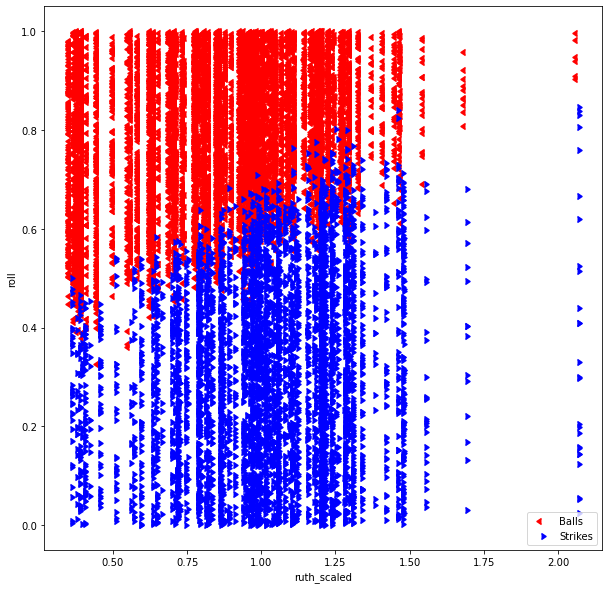

In [11]:
x_val = "ruth_scaled"
# x_val = "svc_best"
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Balls",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Strikes",
    marker=CARETRIGHTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_xlim(0.484, 0.499)

ax.legend()

# fig.savefig(x_val + ".png", facecolor="white")

In [12]:
dfc.groupby(["batting_team_mods"]).size()

batting_team_mods
0;CARCINIZATION;UNHOLEY                        475
0;SHAME_GIVER                                   40
A;AA;GOOD_RIDDANCE;TRAVELING                    22
A;ACIDIC;GOOD_RIDDANCE;TRAVELING                49
AA;AFFINITY_FOR_CROWS                          204
AAA                                            880
AAA;SHAME_GIVER                                 45
ACIDIC;SUN_KISSED;SUN2_PAYOUTS                 194
AFFINITY_FOR_CROWS;AA                           68
BASE_INSTINCTS                                 757
BIRD_SEED                                      632
BLACKHOLE_PAYOUTS;BOTTOM_DWELLER               390
BOTTOM_DWELLER;BLACKHOLE_PAYOUTS               235
ELECTRIC;0;CARCINIZATION;UNHOLEY                27
ELECTRIC;BASE_INSTINCTS                         29
ELECTRIC;LIFE_OF_PARTY                         489
FIERY;AMBUSH;SEALANT;FIREPROOF                 228
FIERY;FIREPROOF;SEALANT;AMBUSH                  99
FIERY;GOOD_RIDDANCE;TRAVELING;A                 65
FIREPROOF;SEA

## SVC fit

In [13]:
# X = dfc[['passed', 'roll', 'ruth_vibes', 'ballpark_forwardness', 'musc_scaled']].copy()
X = dfc[["passed",
         "roll",
         "ruth_vibes",
         # "pitcher_coldness",
         "cold_vibes",
         # "ruth_cold",
         # "opw_vibes",
         # "shakes_vibes",
         # "supp_vibes",
         # "unthwk_vibes",
         "ballpark_forwardness",
         # 'ballpark_grandiosity',
         # 'ballpark_fortification',
         # 'ballpark_obtuseness',
         # 'ballpark_ominousness',
         # 'ballpark_inconvenience',
         # 'ballpark_viscosity',
         # 'ballpark_mysticism',
         # 'ballpark_elongation',
         "musc_scaled",
         "mox_scaled",
         # "batter_base_thirst",
         # "batter_continuation",
         # "batter_ground_friction",
         # "batter_indulgence",
         # "batter_laserlikeness",
         # "batting_team_hype",
         # "pitching_team_hype",
         ]].copy()
X = X[X["roll"] < 0.85]
# X["roll"] = X["roll"] - 0.2 * X["ballpark_forwardness"]
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = None
# pin_intercept = 0.33
pins = [
    # (-0.075, "batting_team_hype"),
    # (0.060, "pitching_team_hype"),
    # (0.295, "ruth_cold"),
    # (0.12, "ballpark_forwardness"),
    # (0.08, "musc_scaled"),
    # (-0.095, "mox_scaled"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]
    
print(X["roll"].max())
print(X.shape)

0.849990562343053
(12649, 6)


In [14]:

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

# sc = StandardScaler()
# X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                           tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)

[[6533   49]
 [  73 5994]]
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      6582
        True       0.99      0.99      0.99      6067

    accuracy                           0.99     12649
   macro avg       0.99      0.99      0.99     12649
weighted avg       0.99      0.99      0.99     12649

0.990354968772235
0.33161956815232224 , intercept
(0.2675288849736745, 'ruth_vibes')
(0.027002290111367098, 'cold_vibes')
(0.11792943309068264, 'ballpark_forwardness')
(0.07911571441565457, 'musc_scaled')
(-0.09454719236307578, 'mox_scaled')


## Calculate threshold from fit

In [15]:
if flinch_data:
    intercept = 0.50
else:
    intercept = 0.30
if season == 11:
    dfc["threshold"] = (intercept
                        + 0.35 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.90
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season == 12 or season == 13:
    dfc["threshold"] = (intercept
                        + 0.30 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.85
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season in [14, 15, 16, 17]:
    dfc["threshold"] = (intercept
                        + 0.285 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
# elif season == 18:
#     intercept = 0.275 # 1/3
#     dfc["threshold"] = (intercept
#                         + 0.275 * dfc["ruth_vibes"] # + 0.285 * dfc["ruth_vibes"]
#                         + 0.025 * dfc["cold_vibes"] # + 0.0285 * dfc["cold_vibes"]
#                         + 0.115 * dfc["ballpark_forwardness"] # + 0.125 * dfc["ballpark_forwardness"]
#                         + 0.075 * dfc["musc_scaled"] # + 0.08 * dfc["musc_scaled"]
#                         - 0.095 * dfc["mox_scaled"] # - 0.10 * dfc["mox_scaled"]
#                        )
#     dfc["svc"] = dfc["threshold"] - intercept
#     strikemax = 0.85
#     dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
else:
    intercept = intercept_scaled
    dfc['threshold'] = intercept_scaled
    print(intercept_scaled)
    for pair in pins + list(zip(-np.array(coef_list), X.columns)):
        if pair[1] != "roll":
            print(pair)
            dfc['threshold'] += pair[0] * dfc[pair[1]]
    # dfc['threshold'] += 0.2 * dfc['ballpark_forwardness']
    dfc["svc"] = dfc["threshold"] - intercept_scaled
    strikemax = 0.85
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax


# dfc['svc'] = 0
# # print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] != "roll":
#         # print(pair)
#         dfc['svc'] += pair[0] * dfc[pair[1]]
# dfc['svc'] += 0.2 * dfc['ballpark_forwardness']

# kidror's rounding:
#  0.275 + 0.275*ruth + 0.115*dfc["ballpark_forwardness"] + 0.075*dfc["batter_musclitude"]
# - 0.095*dfc["batter_moxie"] + 0.025*cold

0.33161956815232224
(0.2675288849736745, 'ruth_vibes')
(0.027002290111367098, 'cold_vibes')
(0.11792943309068264, 'ballpark_forwardness')
(0.07911571441565457, 'musc_scaled')
(-0.09454719236307578, 'mox_scaled')


In [16]:
dfc_strikes = dfc[dfc["event_type"] == "StrikeLooking"]
dfc_flinch = dfc[dfc["event_type"] == "StrikeFlinching"]
dfc_balls = dfc[dfc["event_type"] == "Ball"]

## Find Outliers

,offset,pitcher_mul,batter_mul,event_type,roll,threshold,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count,weather
113329,-0.026093,1.00,1.05,Ball,0.545085,0.571177,Simon Haley,Jenkins Good,FLINCH,FRIEND_OF_CROWS;ALTERNATE,A;AA;GOOD_RIDDANCE;TRAVELING,H20;HIGH_PRESSURE,22,dc83e6eb-f00c-404d-8233-7cf43494261c,12,Weather.BLACK_HOLE
39485,-0.019834,1.00,1.00,Ball,0.513775,0.533608,Trinity Smaht,Lucas Petty,NaN,NaN,UNHOLEY;CARCINIZATION;0,NaN,27,6f5ec1ee-c264-45e5-8118-dce3a16a3863,171,Weather.REVERB
426262,-0.019134,1.00,1.00,Ball,0.579294,0.598428,Oliver Loofah,King Roland,MINIMALIST,NaN,GOOD_RIDDANCE;TRAVELING;A;0,LOVE,45,2a314b60-a36b-4e22-bee8-5da17c8e0d05,221,Weather.SALMON
424040,-0.015602,1.00,1.00,Ball,0.752857,0.768459,Lachlan Shelton,Sixpack Santiago,SLOW_BUILD,BLASERUNNING,HIGH_PRESSURE;H20,LIFE_OF_PARTY;ELECTRIC,43,ca91bab2-de95-4202-8ee5-4144dbd66da5,290,Weather.FLOODING
428579,-0.015588,1.00,1.00,Ball,0.651883,0.667471,Foxy Pebble,Snyder Briggs,NaN,ALTERNATE;WILD,LOVE,GOOD_RIDDANCE;TRAVELING;A;O_NO,47,1d31176d-d184-44ec-a94b-959bf4f7e3fa,124,Weather.BLOODDRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98608,0.021825,1.00,1.00,StrikeLooking,0.619351,0.597526,Usurper Violet,Parker Meng,SOUNDPROOF,ALTERNATE;PERK;MINIMALIST,AA;AFFINITY_FOR_CROWS,0;CARCINIZATION;UNHOLEY,9,b72a2eb5-df05-4d9d-a5d9-5e30737f3522,264,Weather.SUN_2
97608,0.022041,1.00,1.00,StrikeLooking,0.526380,0.504340,Brock Watson,Rivers Rosa,NaN,NaN,NaN,BLACKHOLE_PAYOUTS;BOTTOM_DWELLER,9,3167e4e8-ae90-477f-9fca-b8797b9ecdad,25,Weather.ECLIPSE
39593,0.034402,1.00,1.00,StrikeLooking,0.571810,0.537408,Hatfield Suzuki,Jenkins Good,NaN,FRIEND_OF_CROWS;ALTERNATE,BIRD_SEED,HIGH_PRESSURE;H20,27,42abc7c8-de7b-4b90-a6e0-d196d7f8dcf2,197,Weather.BIRDS
601254,0.036867,1.25,1.00,StrikeLooking,0.653805,0.616938,Helga Moreno,Jenkins Good,NaN,ALTERNATE;FRIEND_OF_CROWS,LOVE,H20;HIGH_PRESSURE,17,694eec94-4551-4904-af42-2054ea3d97b5,230,Weather.FLOODING


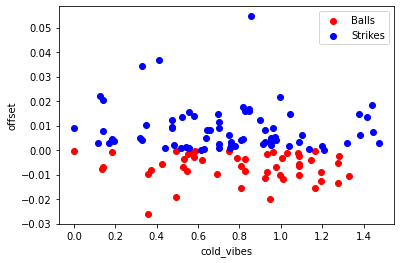

In [17]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "cold_vibes"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Balls",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Strikes",
)

ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers

# table.groupby(["batting_team_mods"]).size()
# pd.set_option("display.max_rows", 100)  # default 60
outliers_by_pitcher = table.groupby(["pitcher_name"]).size()
pitches_by_pitcher = dfc.groupby(["pitcher_name"]).size()

outlier_fraction = pitches_by_pitcher.copy()
for pitcher in outlier_fraction.index:
    if pitcher in outliers_by_pitcher.index:
        outlier_fraction[pitcher] = outliers_by_pitcher[pitcher]/pitches_by_pitcher[pitcher]
    else:
        outlier_fraction[pitcher] = 0


outliers_by_batter = table.groupby(["batter_name"]).size()
pitches_by_batter = dfc.groupby(["batter_name"]).size()

outlier_fraction_b = pitches_by_batter.copy()
for batter in outlier_fraction_b.index:
    if batter in outliers_by_batter.index:
        outlier_fraction_b[batter] = outliers_by_batter[batter]/pitches_by_batter[batter]
    else:
        outlier_fraction_b[batter] = 0
# outlier_fraction.sort_values()
# dfc.groupby(["pitcher_name"]).size().sort_values()
# print(outliers.groupby("season").size())

table[#.loc[table["pitcher_name"] == "Jenkins Good",
    [
        "offset",  # "home_score", "away_score", "top_of_inning", "inning",
        "pitcher_mul",
        "batter_mul",
        "event_type",
        "roll",
        "threshold",
        # "svc",
        # "ruth_vibes",
        # "batter_musclitude",
        # "batter_moxie",
        # "ballpark_forwardness",
        # "pitcher_coldness",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
        "weather",
         # 'ball_count',
         # 'strike_count',
         # 'out_count'
    ]
].sort_values("offset")

pitcher_name
Fitzgerald Wanderlust    0.000000
Evelton McBlase          0.000000
Mags Banananana          0.000000
Stevenson Heat           0.000000
Greer Gwiffin            0.000000
                           ...   
Conrad Twelve            0.020408
Brock Forbes             0.024194
Snyder Briggs            0.026549
Lucas Petty              0.031250
Jenkins Good             0.033113
Length: 99, dtype: float64


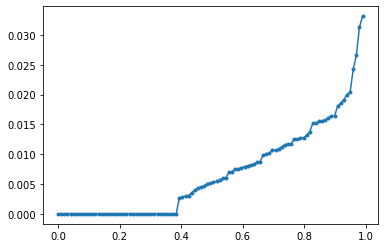

In [18]:
plt.plot(np.arange(len(outlier_fraction))/len(outlier_fraction), outlier_fraction.sort_values(), '.-')
# plt.plot(np.arange(len(outlier_fraction_b))/len(outlier_fraction_b), outlier_fraction_b.sort_values(), '.-')
# pd.set_option("display.max_rows", 300)  # default 60
print(outlier_fraction.sort_values())
# print(pitches_by_pitcher.sort_values())
# print(outlier_fraction_b.sort_values())
# pd.set_option("display.max_rows", 60)  # default 60

## Visualize Threshold

Text(0.5, 0.98, 'Season 19, Non-Flinching')

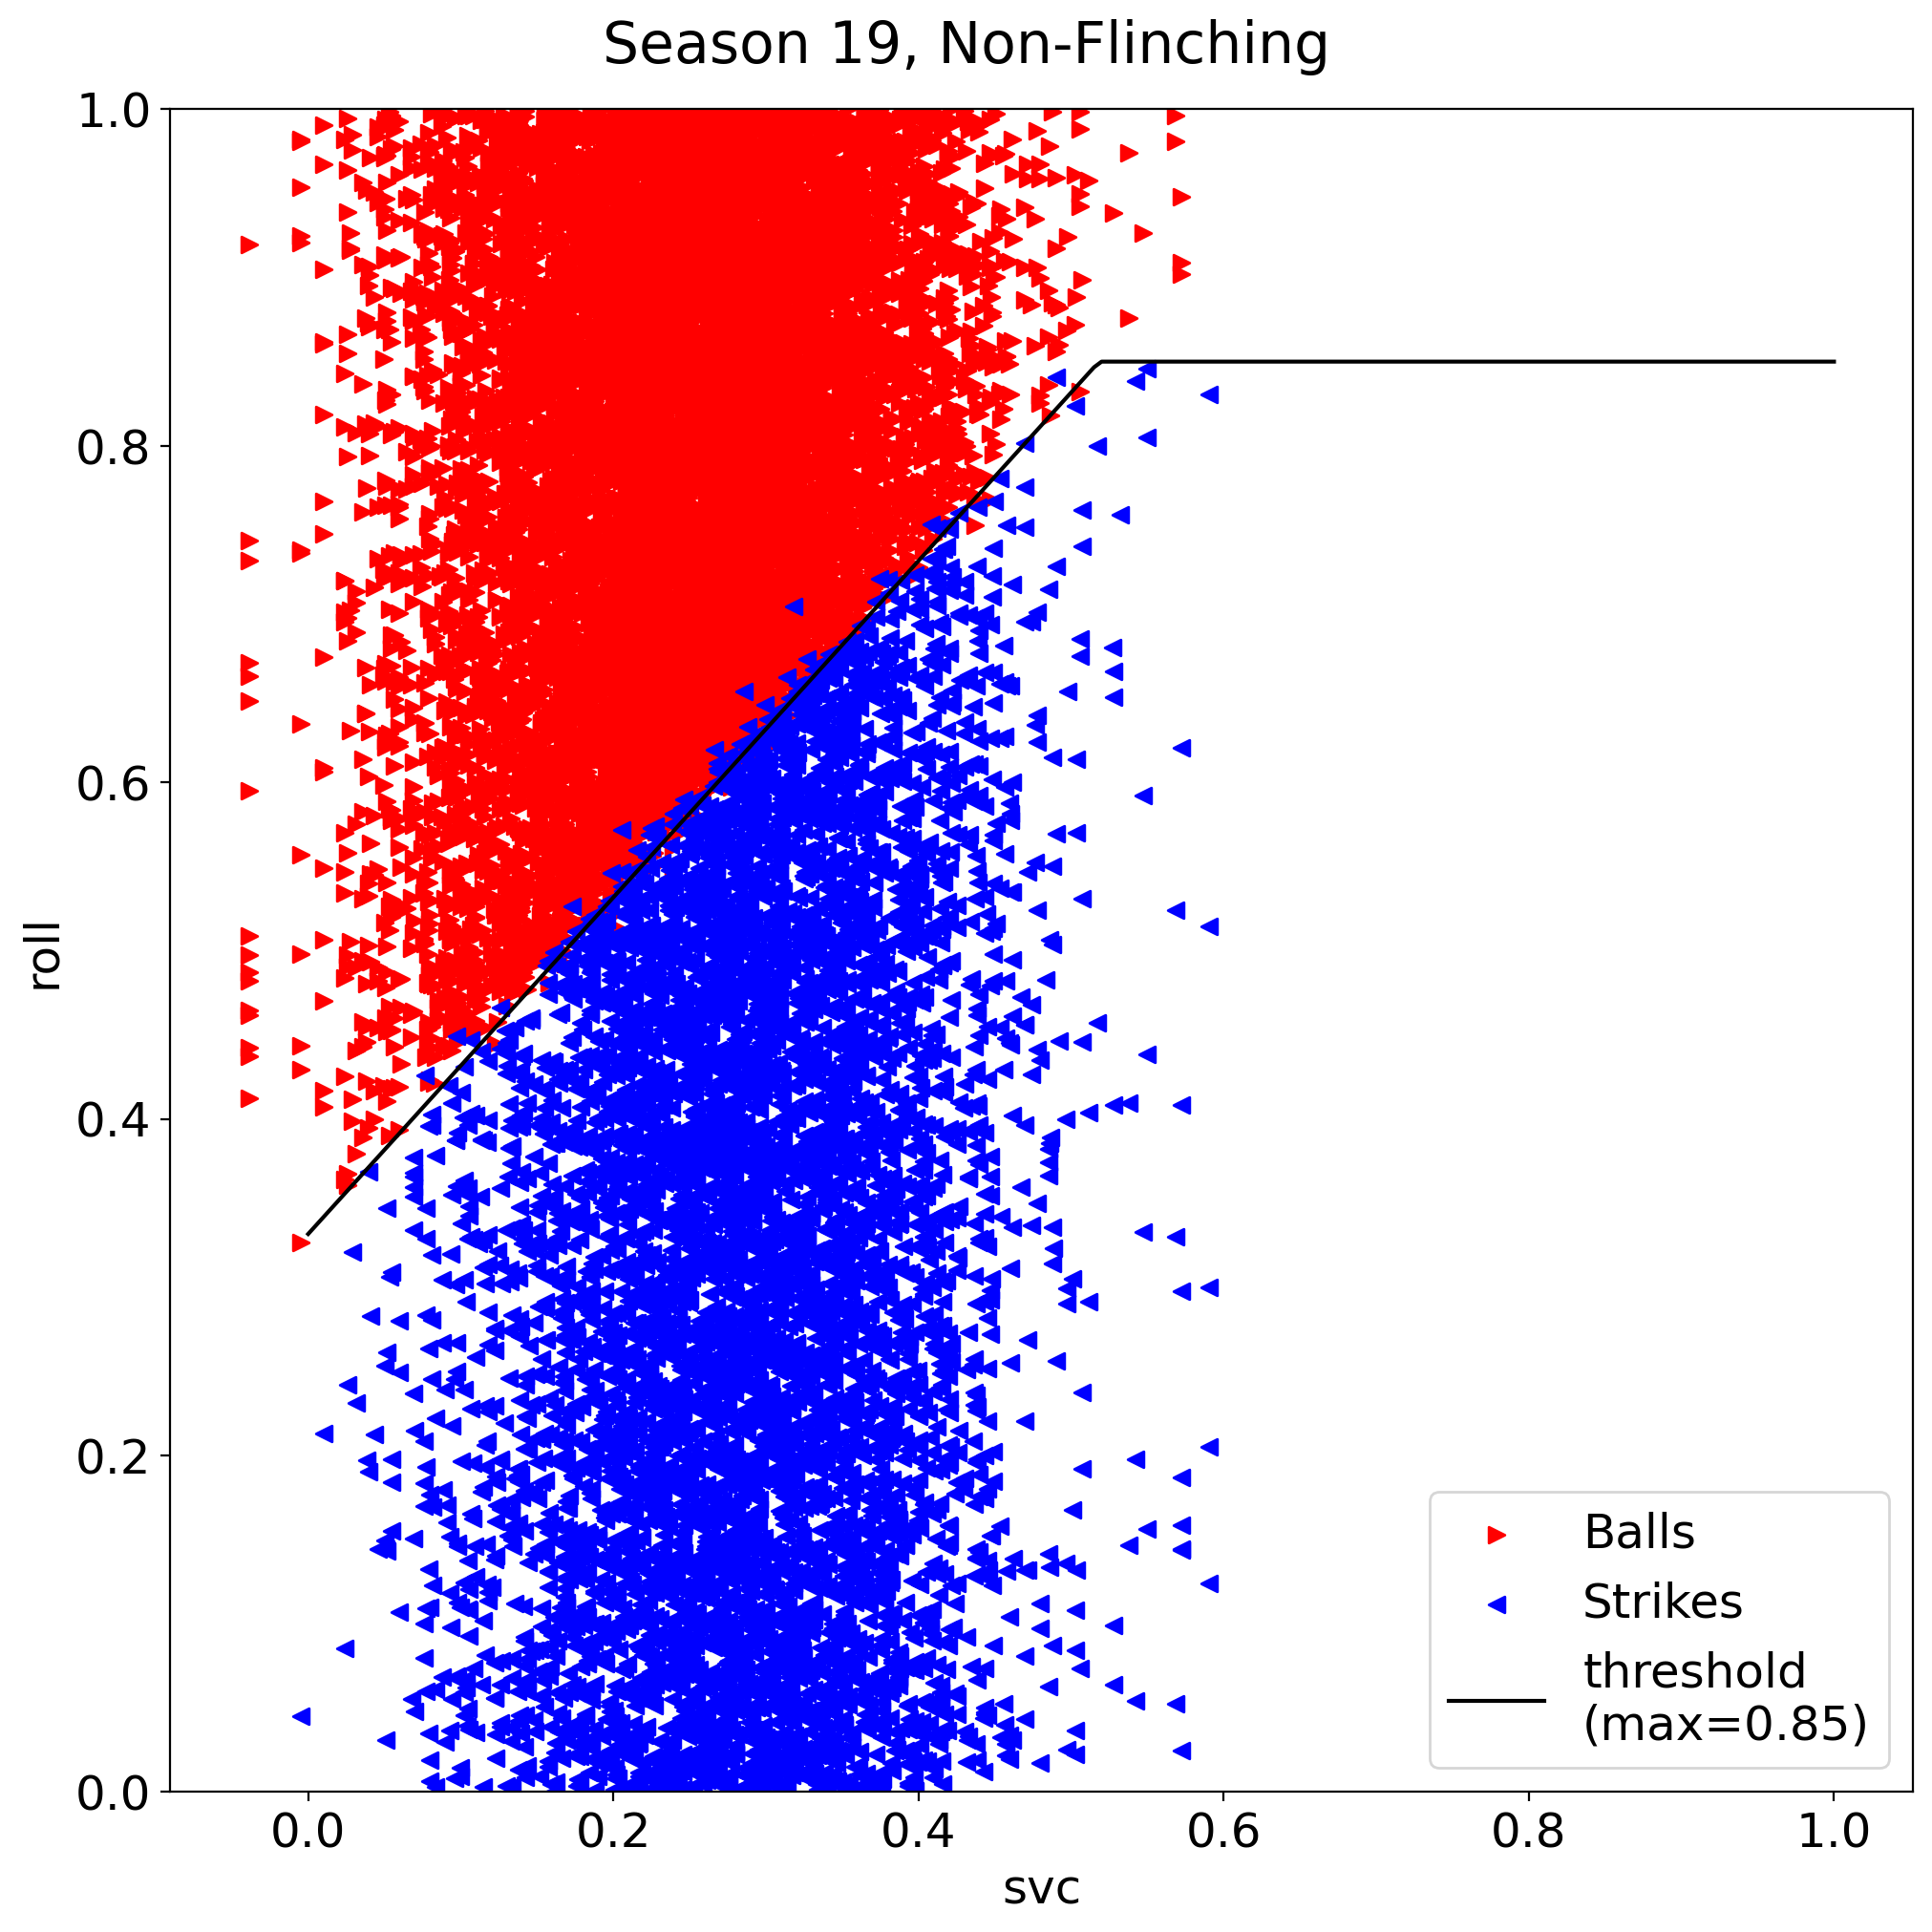

In [19]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "svc"
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=200, layout="constrained")

intercept_plot = intercept
# intercept_plot = -intercept_scaled
xline = np.linspace(0, 1, 201)
# xline = np.insert(xline, 1, 0.65)
yline = intercept_plot + xline
# yline = xline
yline[(yline > strikemax)] = strikemax

# ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Balls",
    marker=">",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Strikes",
    marker="<",
)
# ax.set_xlim(-0.05, 1.05)
ax.plot(xline, yline, "k", label=f"threshold\n(max={strikemax})")
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="red", label="Balls (below threshold)", marker='<')
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="blue", label="Strikes (above threshold)", marker='>')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.plot(dfc["svc"].min(), 0.5, 'o')

ax.legend(loc="lower right")
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching")
# fig.savefig(f"../figures/strikes_s{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white', dpi=200)


In [20]:
outliers.groupby("season").size()

season
18    122
dtype: int64

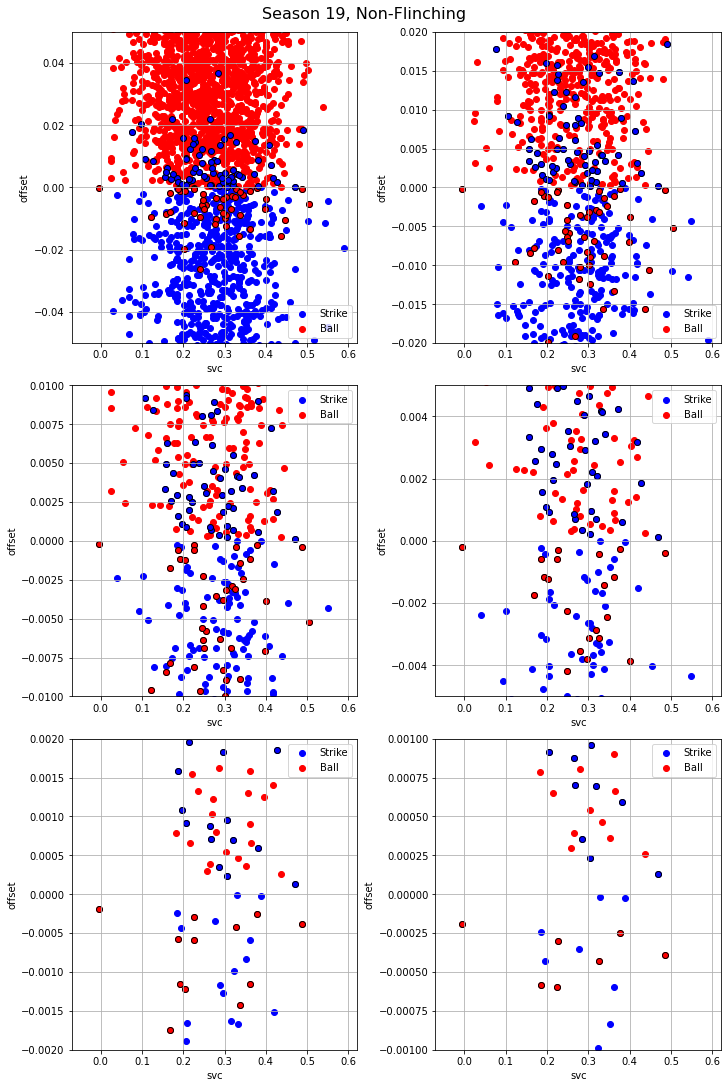

In [21]:
plt.rcParams["font.size"] = 10
x_val = "svc"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Strike",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Ball",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig(f"../figures/ball_strike_fit_offsets_season{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white')


In [22]:
# cutoff = 0.85 + intercept_scaled[0]
cutoff = 0.85 - intercept
print(round(cutoff, 6))
print(dfc_balls['roll'].max())
print(dfc_flinch['roll'].max())
print(dfc_strikes['roll'].max())
# print(dfc_balls[dfc_balls['svc'] > cutoff]['roll'].min())
# print(dfc_balls[dfc_balls['svc'] > cutoff]['roll'].argmin())
# dfc_balls[dfc_balls['svc'] > cutoff].iloc[dfc_balls[dfc_balls['svc'] > cutoff]['roll'].argmin(),:]
# print(dfc_flinch[dfc_flinch['svc'] > 0.85 + intercept_scaled[0]]['roll'].max())

0.51838
0.9999952780379446
nan
0.845657853377279


In [23]:
print(dfc_balls['roll'].min())
print(dfc_flinch['roll'].min())
print(dfc_strikes['roll'].min())

0.3265759853975571
nan
4.526680272132211e-05


In [24]:
0.85 - intercept_scaled

0.5183804318476777

In [25]:
# df["svc"].min()

In [26]:
# df["svc_best"].max()

In [27]:
# df.iloc[df["svc_best"].argmax(), :][70:]

In [28]:
# dfc["threshold"] = -1 * (\
#     1.0 * -0.20 + \
#     -0.30 * dfc["ruth_scaled"] + \
#     -0.20 * dfc["ballpark_forwardness"] + \
#     -0.10 * dfc["musc_scaled"] + \
#     -0.06 * dfc["ruth_vibes"])
# dfc["threshold"] = -1 * (\
#     coef_scaled[0,0] * intercept_scaled + \
#     coef_scaled[0,1] * dfc["ruth_scaled"] + \
#     coef_scaled[0,2] * dfc["ballpark_forwardness"] + \
#     coef_scaled[0,3] * dfc["ruth_vibes"] + \
#     coef_scaled[0,4] * dfc["musc_scaled"] + \
#     coef_scaled[0,5] * dfc["flinch"])
# dfc.loc[(dfc["threshold"] > 0.85), "threshold"] = 0.85


# dfc["offset"] = dfc["roll"] - dfc["threshold"]

# outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
# print(len(outliers))

# fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 10)
# x_val = "svc"
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="Balls")
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Strikes")
# ax.set_xlabel(x_val)
# ax.set_ylabel('offset')
# ax.grid()
# ax.legend()
# ax.set_xlim(0, 1.4)
# ax.set_xlim(0.1, 0.7)
# ax.set_ylim(-0.06, 0.08)
# fig.savefig("fit_outliers.png", facecolor='white')

In [29]:
dfc_flinch.loc[:,["roll", "ruth_vibes", "pitcher_name", "svc"]].sort_values("ruth_vibes")

,roll,ruth_vibes,pitcher_name,svc


In [30]:
dfc_flinch["svc"].min()

nan

In [31]:
df_strikes = df[df["event_type"] == "StrikeLooking"]
df_flinch = df[df["event_type"] == "StrikeFlinching"]
df_balls = df[df["event_type"] == "Ball"]

In [32]:
print(df_balls['roll'].min())
print(df_flinch['roll'].min())
print(df_strikes['roll'].min())

0.009235878301657
0.0004467073582588
4.526680272132211e-05


In [33]:
print(df_balls['roll'].max())
print(df_flinch['roll'].max())
print(df_strikes['roll'].max())

0.9999952780379446
0.851811635301063
0.845657853377279


In [34]:
game = dfc[(dfc["game_id"] == "7d782994-a4fb-469d-9942-e97def670e23") & (dfc["batter_name"] == "Zesty Yaboi")]
game[digest_list]

,event_type,roll,threshold,batter_name,pitcher_name,ruth_vibes,musc_scaled,mox_scaled,ballpark_forwardness,game_id,play_count
100862,StrikeLooking,0.164698,0.594356,Zesty Yaboi,Famous Owens,0.925819,0.456165,0.435468,0.018072,7d782994-a4fb-469d-9942-e97def670e23,154
